In [1]:
!pip install category_encoders
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.6 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
#from sklearn. preprocessing import OneHotEncoder
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
import streamlit as st
import pickle

# **Data Cleaning**

In [3]:
# Create Wrangle function for data cleaning
def wrangle(path):
    # Read in data as dataframe
    df = pd.read_csv(path)
    drop_cols = []

    # Define a function to clean and extract numeric values
    def clean_price(price_str):
        # Use regular expressions to extract numeric values
        match = re.search(r'\d+(,\d+)*', price_str)
        if match:
            cleaned_price = match.group(0)  # Extract the matched numeric part
            # Remove commas and convert to integer
            cleaned_price = int(cleaned_price.replace(',', ''))
            return cleaned_price
        else:
            return None  # Return None if no numeric value is found

    # Apply the cleaning function to the "price" column
    df['cleaned_price'] = df['Price'].apply(clean_price)

    # Define a function to convert based on rate type
    def convert_price(row):
        if '/year' in row['Price']:
            return row['cleaned_price']
        elif '/month' in row['Price']:
            return row['cleaned_price'] * 12
        elif '/day' in row['Price']:
            return row['cleaned_price'] * 365
        else:
            return row['cleaned_price']

    # Apply the conversion function to the DataFrame
    df['converted_price'] = df.apply(convert_price, axis=1)

    # Rename Converted price column
    df = df.rename(columns={'converted_price': 'Apartment Price'})

    # Append column to drop to drop_cols
    drop_cols.append('cleaned_price')
    drop_cols.append('Price')
    drop_cols.append('Serviced')


    # Clean Bedroom Column
    df['Bedrooms'] = df['Bedrooms'].str.replace(' beds','').str.strip()

    # Clean Bathroom Column
    df['Bathrooms'] = df['Bathrooms'].str.replace(' baths','').str.strip()

    # Clean Toilet Column
    df['Toilets'] = df['Toilets'].str.replace(' Toilets','').str.strip()

    # Convert to integers, handling empty strings
    df['Bedrooms'] = df['Bedrooms'].apply(lambda x: int(x) if x.isdigit() else 0)
    df['Bathrooms'] = df['Bathrooms'].apply(lambda x: int(x) if x.isdigit() else 0)
    df['Toilets'] = df['Toilets'].apply(lambda x: int(x) if x.isdigit() else 0)

    # Define a mapping of standardized categories
    category_mapping = {
    'Semi Detached Duplex': ['Semi Detached House', 'Superb 4 Bedroom Semi Detached Duplex'],
    'Terrace Duplex': ['Terrace Duplex', 'Furnished 2 Bedroom Terrace Duplex For Rent !!!'],
    'Mini Flat': ['Mini Flat', 'A Fairly Used But Clean Mini Flat At Fola Agoro To Let.'],
    'Room Self Contain': ['Riomself Contained'],
    'Fully Detached Duplex': ['Newly Built 4 Bedroom Semi Detached House With Bq'],
    'Flat': ['Flat']  # Include titles containing 'Flat' in the 'Flat' category
}

    # Create a function to map the values to the standardized categories
    def feature_engineering(title):
        for category, keywords in category_mapping.items():
            for keyword in keywords:
                if keyword in title:
                    return category
        return 'Other'  # If no match, return 'Other' category

    # Create a new feature based on feature engineering
    df['Title'] = df['Title'].apply(feature_engineering)

    # Drop the more info column
    drop_cols.append("More Info")

    # Drop Columns
    df.drop(columns=drop_cols, inplace=True)

    return df

# **Exploratory Data Analysis**

In [4]:
# Read in data as DataFrame using wrangle function
df = wrangle('/content/lagos-rent.csv')
df.head()

,Title,Newly Built,Furnished,Bedrooms,Bathrooms,Toilets,City,Neighborhood,Apartment Price
0,Semi Detached Duplex,1,0,4,4,5,Lekki,Agungi,5000000
1,Semi Detached Duplex,1,0,4,4,5,Lekki,Other Lekki,5000000
2,Terrace Duplex,0,0,2,3,3,Lekki,Osapa London,3500000
3,Other,1,0,2,3,3,Lekki,Ologolo,2700000
4,Terrace Duplex,0,0,4,5,5,Lekki,Chevron,4000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53070 entries, 0 to 53069
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            53070 non-null  object
 1   Newly Built      53070 non-null  int64 
 2   Furnished        53070 non-null  int64 
 3   Bedrooms         53070 non-null  int64 
 4   Bathrooms        53070 non-null  int64 
 5   Toilets          53070 non-null  int64 
 6   City             53070 non-null  object
 7   Neighborhood     53070 non-null  object
 8   Apartment Price  53070 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 3.6+ MB


In [6]:
df.describe()

,Newly Built,Furnished,Bedrooms,Bathrooms,Toilets,Apartment Price
count,53070.00000,53070.000000,53070.000000,53070.000000,53070.000000,5.307000e+04
mean,0.28306,0.115640,2.424854,2.229697,2.627907,4.708438e+07
std,0.45049,0.319795,1.506096,1.661991,1.943429,7.389011e+09
min,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,0.00000,0.000000,1.000000,1.000000,1.000000,9.000000e+05
50%,0.00000,0.000000,3.000000,2.000000,3.000000,2.000000e+06
75%,1.00000,0.000000,3.000000,3.000000,4.000000,4.500000e+06
max,1.00000,1.000000,10.000000,10.000000,10.000000,1.700000e+12


In [7]:
df['Title'].unique()

array(['Semi Detached Duplex', 'Terrace Duplex', 'Other', 'Flat',
       'Mini Flat', 'Room Self Contain'], dtype=object)

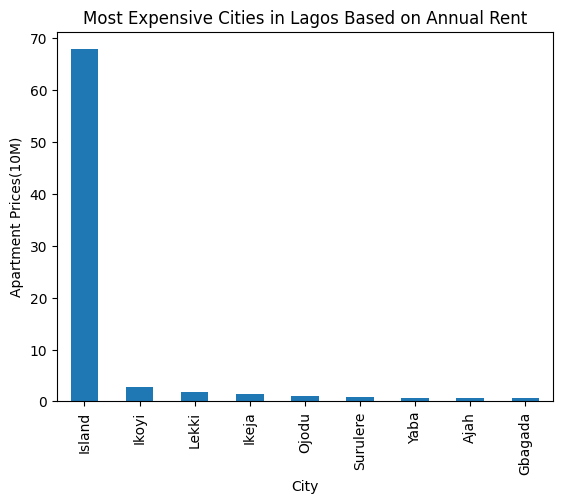

In [8]:
# Visualization apartment prices based on city
(
    (df.groupby("City")['Apartment Price']
    .mean()/1e7)
    .sort_values(ascending=False)
    .plot(kind="bar",
         xlabel = 'City',
         ylabel = "Apartment Prices(10M)",
         title = "Most Expensive Cities in Lagos Based on Annual Rent")
);

In [9]:
# Dealing with suspected outlier
trim = q1, q9 = df["Apartment Price"].quantile([0.1, 0.9])
mask = df["Apartment Price"].between(q1,q9)
df= df[mask]

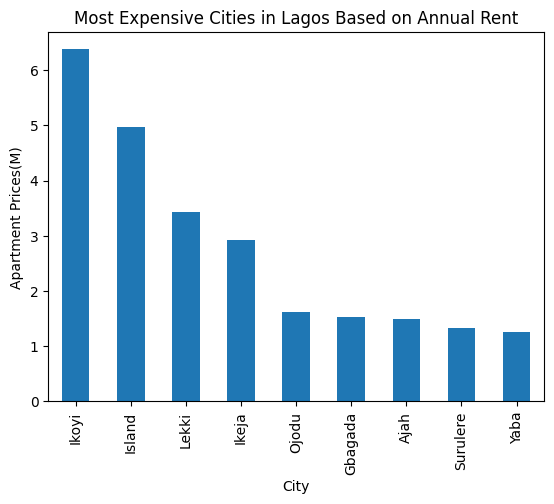

In [10]:
# Visualization apartment prices based on city
(
    (df.groupby("City")['Apartment Price']
    .mean()/1e6)
    .sort_values(ascending=False)
    .plot(kind="bar",
         xlabel = 'City',
         ylabel = "Apartment Prices(M)",
         title = "Most Expensive Cities in Lagos Based on Annual Rent")
);

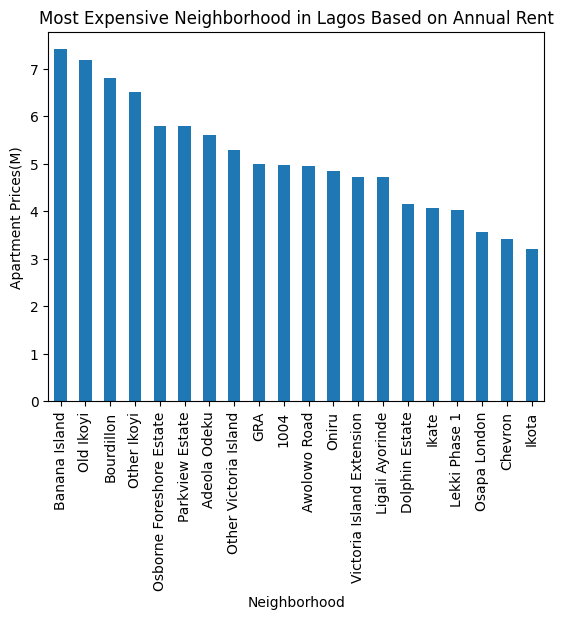

In [11]:
# Visualization apartment prices based on Neigborhood
(
    (df.groupby("Neighborhood")['Apartment Price']
    .mean()/1e6)
    .sort_values(ascending=False).head(20)
    .plot(kind="bar",
         xlabel = 'Neighborhood',
         ylabel = "Apartment Prices(M)",
         title = "Most Expensive Neighborhood in Lagos Based on Annual Rent")
);

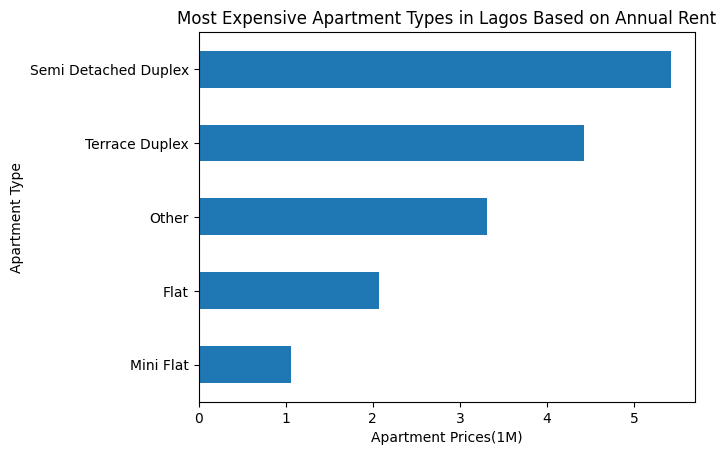

In [12]:
# Visualization apartment prices based on Neigborhood
(
    (df.groupby("Title")['Apartment Price']
    .mean()/1e6)
    .sort_values().head(20)
    .plot(kind="barh",
         xlabel = 'Apartment Prices(1M)',
         ylabel = "Apartment Type",
         title = "Most Expensive Apartment Types in Lagos Based on Annual Rent")
);

<ipython-input-13-c9e00700e317>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

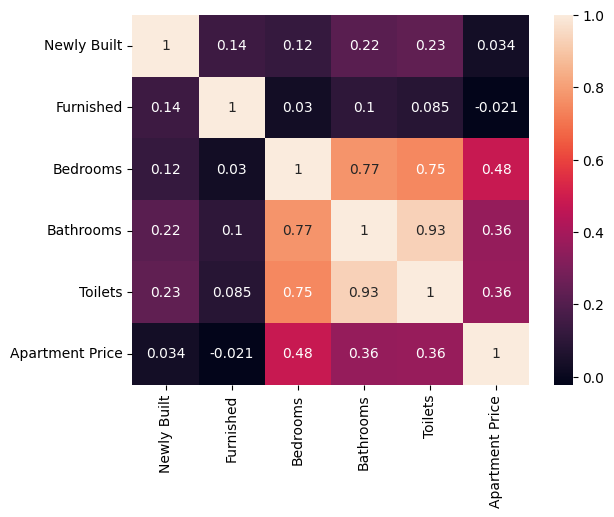

In [13]:
# Check for Correlation between numerical variables
corr = df.corr()
sns.heatmap(corr, annot=True)

# **Split the data**

In [14]:
# Split the data in features and target variables
X = df.drop(columns=['Apartment Price', 'Bathrooms', 'Neighborhood'])
y = df['Apartment Price']

In [15]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Train the model**

In [16]:
# Calculate baseline model
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("The Mean Price is", round(y_mean, 2))
print("The Mean Absolute Error is", round(mae_baseline, 2))

The Mean Price is 2679182.0
The Mean Absolute Error is 1684665.23


In [17]:
# Create Pipeline for Linear Model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Title', 'City'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

In [18]:
y_train_pred = model.predict(X_train)
y_train_mae = mean_absolute_error(y_train, y_train_pred)
print("The Mean Absolute Error of the Training Data is", y_train_mae)

The Mean Absolute Error of the Training Data is 990012.8630670909


In [19]:
y_test_pred = model.predict(X_test)
y_test_mae = mean_absolute_error(y_test, y_test_pred)
print("The Mean Absolute Error of the Test Data is", y_test_mae)

The Mean Absolute Error of the Test Data is 993332.4983952316


In [20]:
test_result_data = pd.DataFrame({'test_price': y_test, 'prediction_price': y_test_pred})
test_result_data = test_result_data.reset_index(drop=True)
test_result_data.head()

,test_price,prediction_price
0,3500000,3162880.0
1,800000,2144512.0
2,650000,624512.0
3,1200000,1481600.0
4,1500000,1191552.0


Text(0, 0.5, 'Apartment Prices(M)')

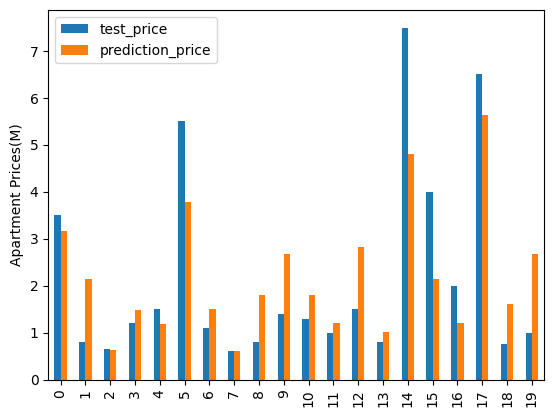

In [21]:
(test_result_data/1e6).head(20).plot(kind="bar")
plt.ylabel("Apartment Prices(M)")

In [22]:
# Cross Validtion Techniques to improve model
# Define the number of folds for cross-validation
k = 10

# Create a cross-validation object (e.g., k-fold cross-validation)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation and calculate MAE for each fold
mae_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kf)

# Convert negative MAE scores to positive
mae_scores = -mae_scores

# Calculate the average MAE across all folds
average_mae = mae_scores.mean()

# Print the MAE scores for each fold and the average MAE
print("MAE scores for each fold:", mae_scores)
print("Average MAE:", average_mae)

MAE scores for each fold: [1008982.83975241  979318.56602476 1013032.66804218  983790.48899587
  994206.90916149  987879.31224209  966476.01352591 1005434.31323091
  990192.86035313  995597.50103187]
Average MAE: 992491.1472360624


# Communicating the results

In [23]:
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("intercept:", intercept)
print(coefficients[:5])

intercept: 8.387818860088326e+17
[-9.61492828e+17 -9.61492828e+17 -9.61492828e+17 -9.61492828e+17
 -9.61492828e+17]


In [24]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print(feature_names)

['Title_Mini Flat' 'Title_Terrace Duplex' 'Title_Flat' 'Title_Other'
 'Title_Semi Detached Duplex' 'Newly Built' 'Furnished' 'Bedrooms'
 'Toilets' 'City_Gbagada' 'City_Island' 'City_Lekki' 'City_Yaba'
 'City_Surulere' 'City_Ikeja' 'City_Ajah' 'City_Ojodu' 'City_Ikoyi']


/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


In [25]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

Title_Mini Flat              -9.614928e+17
Title_Terrace Duplex         -9.614928e+17
Title_Flat                   -9.614928e+17
Title_Other                  -9.614928e+17
Title_Semi Detached Duplex   -9.614928e+17
dtype: float64

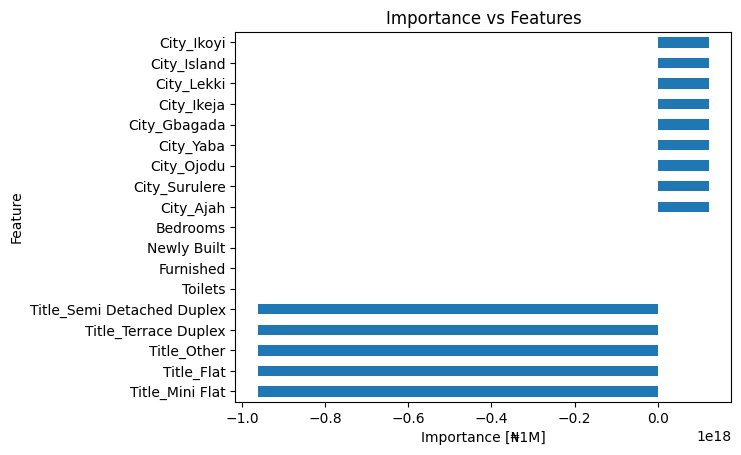

In [26]:
feat_imp.sort_values().plot(kind="barh")
plt.xlabel("Importance [₦1M]")
plt.ylabel("Feature")
plt.title("Importance vs Features");

# Making Predictions

In [27]:
def make_prediction(Title, NewlyBuilt, Furnished,Bedrooms, Toilets, City):
    data = {
        "Title": Title,
        "Newly Built": NewlyBuilt,
        "Furnished": Furnished,
        "Bedrooms": Bedrooms,
        "Toilets": Toilets,
        "City": City
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ₦{prediction}"

In [28]:
make_prediction('Semi Detached Duplex',1,0,4,4,'Surulere')

'Predicted apartment price: ₦4135296.0'

In [29]:
interact(
    make_prediction,
    Title=Dropdown(options=sorted(X_train["Title"].unique())),
    NewlyBuilt=Dropdown(options=sorted(X_train["Newly Built"].unique())),
    Furnished =Dropdown(options=sorted(X_train["Furnished"].unique())),
    Bedrooms=IntSlider(
        min=X_train["Bedrooms"].min(),
        max=X_train["Bedrooms"].max(),
        value=X_train["Bedrooms"].mean(),
    ),
    Toilets=IntSlider(
        min=X_train["Toilets"].min(),
        max=X_train["Toilets"].max(),
        step=1,
        value=X_train["Toilets"].mean(),
    ),
    City=Dropdown(options=sorted(X_train["City"].unique())),
);

interactive(children=(Dropdown(description='Title', options=('Flat', 'Mini Flat', 'Other', 'Semi Detached Dupl…

In [30]:
# Trying Streamlit
#city_options = sorted(X_train["City"].unique())
#title_option
#st.title('Make Predictions')
#Title = st.selectbox()
#Bathrooms = st.slider('Bathrooms', value=2, min_value=1, max_value=10)
#Toilets = st.slider('Toilets', value=2, min_value=1, max_value=10)
#City = st.selectbox('Select a city', city_options)


In [31]:
# Save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)